### Install and Import Dependencies

In [2]:
import os

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import mediapipe as mp
from tensorflow import keras
import tensorflow as tf

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import cv2


The 33 keypoints are in order

0 - nose \
1 - left eye (inner) \
2 - left eye \
3 - left eye (outer) \
4 - right eye (inner) \
5 - right eye \
6 - right eye (outer) \
7 - left ear \
8 - right ear \
9 - mouth (left) \
10 - mouth (right) \
11 - left shoulder \
12 - right shoulder \
13 - left elbow \
14 - right elbow \
15 - left wrist \
16 - right wrist \
17 - left pinky \
18 - right pinky \
19 - left index \
20 - right index \
21 - left thumb \
22 - right thumb \
23 - left hip \
24 - right hip \
25 - left knee \
26 - right knee \
27 - left ankle \
28 - right ankle \
29 - left heel \
30 - right heel \
31 - left foot index \
32 - right foot index 

For squat detection, we don't need to the keypoints 1, 3, 4, and 5 (too much info about eyes), \
9 and 10 (don't need to know mouth position), and 17-22 (info about fingers too detailed, only \
need wrist keypoints)

### Capture Keypoints to CSV

In [3]:
def capture_pose(keypoints, filepath, classification):
    """
    Cleans keypoints data, writes file to csv.  

    :params:
        - keypoints: landmark obj of all 33 keypoints w/ x, y, z, and visibility, 
            already normalized
        - filepath: path of csv file to write to
        - classification: 1 if up position, 0 if down position
    """
    # clean up unwanted keypoints
    keypoints = keypoints[:1] + keypoints[2:3] + keypoints[6:9] + keypoints[11:17] + keypoints[23:33]
    # flatten to 1d vector
    cleaned_kp = np.array([[x.x, x.y, x.z] for x in keypoints], dtype="float64").flatten() 
    cleaned_kp = np.append(cleaned_kp, classification)
    cleaned_kp = cleaned_kp.reshape(1, len(cleaned_kp))
    df = pd.DataFrame(cleaned_kp)

    # write data to cvs
    file_exists = os.path.isfile(filepath)
    if not file_exists:
        df.to_csv(filepath, index=False)
    else:
        df.to_csv(filepath, mode='a', index=False, header=False)

### Capture Data to CSV

In [13]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

video_path = "data\\test_videos\\Video 8-31-23, 10 34 48.mov"
save_path = "data\\test_csv\\squat_data_test_2.csv"

# starts video capture on video
cap = cv2.VideoCapture(video_path)
csv_filepath = save_path

# runs mediapipe pose detection
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        if not ret:
            break

        # changing display colors
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame.flags.writeable = False
        results = pose.process(frame)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        mp_drawing.draw_landmarks(
            frame,
            results.pose_landmarks, 
            mp_pose.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
            )

        cv2.imshow("Webcam Feed", frame)

        k = cv2.waitKey(1)
        if k == ord('u'):
            # captures keypoints for up position
            capture_pose(results.pose_landmarks.landmark, csv_filepath, 1)
        elif k == ord('d'):
            # captures keypoints for down position
            capture_pose(results.pose_landmarks.landmark, csv_filepath, 0)
        elif k == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

### Load CSV Data

In [15]:
def split_train_test(csv_filepath):
    """
    Splits a testing csv dataset into 80/20 split of testing/validation

    :params:
        - csv_filepath: path to csv file

    :returns:
        - X_train: pandas df for training, datapoints
        - x_val: pandas df for training, class labels
        - Y_train:pandas df for validation, datapoints
        - y_val: pandas df for validation, class labels
    """
    # create df from data
    squat_df = pd.read_csv(csv_filepath)
    # split data into train and val
    squat_df['split'] = np.random.randn(squat_df.shape[0], 1)
    mask = np.random.rand(len(squat_df)) <= 0.8

    # training dataset
    X_train = squat_df[mask].astype('float64')
    X_val = squat_df[~mask].astype('float64')
    # corresponding labels
    y_train = keras.utils.to_categorical(X_train.pop('63'))
    y_val = keras.utils.to_categorical(X_val.pop('63'))
    # pop_off_split
    X_train.pop('split')
    X_val.pop('split')

    return X_train, y_train, X_val, y_val

def landmarks_to_embedding(landmarks):
    """
    Converts input landarks to pose embedding

    :params:
        - landmarks: pandas df of the landmarks of dim (21, 3)

    :returns:
        - The landmarks as an embedded vector of dim (51)
    """
    # reshape into matrix with dims (21, 3)
    reshaped_input = keras.layers.Reshape((21, 3))(landmarks)
    return keras.layers.Flatten()(reshaped_input)

### Define Keras Model

In [16]:
inputs = tf.keras.Input(shape=(63))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)

outputs = keras.layers.Dense(2, activation='softmax')(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 63)]              0         
_________________________________________________________________
reshape (Reshape)            (None, 21, 3)             0         
_________________________________________________________________
flatten (Flatten)            (None, 63)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               8192      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0     

### Training Model

In [17]:
data_filepath = 'data\\train_csv\\squat_data_train_2.csv'

X_train, y_train, X_val, y_val = split_train_test(data_filepath)

In [18]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# checkpoint to store highest validation accuracy
checkpoint_path = 'model\\weights\\ weights.{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=20
)

# start training
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=200,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, earlystopping]
)

Epoch 1/200
40/40 [==============================] - 4s 12ms/step - loss: 0.6844 - accuracy: 0.5887 - val_loss: 0.5346 - val_accuracy: 0.8974

Epoch 00001: val_accuracy improved from -inf to 0.89744, saving model to model\weights\ weights.01-0.53.hdf5
Epoch 2/200
40/40 [==============================] - 0s 7ms/step - loss: 0.4960 - accuracy: 0.7834 - val_loss: 0.3154 - val_accuracy: 0.9295

Epoch 00002: val_accuracy improved from 0.89744 to 0.92949, saving model to model\weights\ weights.02-0.32.hdf5
Epoch 3/200
40/40 [==============================] - 0s 6ms/step - loss: 0.2818 - accuracy: 0.9105 - val_loss: 0.1617 - val_accuracy: 0.9551

Epoch 00003: val_accuracy improved from 0.92949 to 0.95513, saving model to model\weights\ weights.03-0.16.hdf5
Epoch 4/200
40/40 [==============================] - 0s 7ms/step - loss: 0.1863 - accuracy: 0.9341 - val_loss: 0.1472 - val_accuracy: 0.9359

Epoch 00004: val_accuracy did not improve from 0.95513
Epoch 5/200
40/40 [========================

### Visualize & Analyze Training History

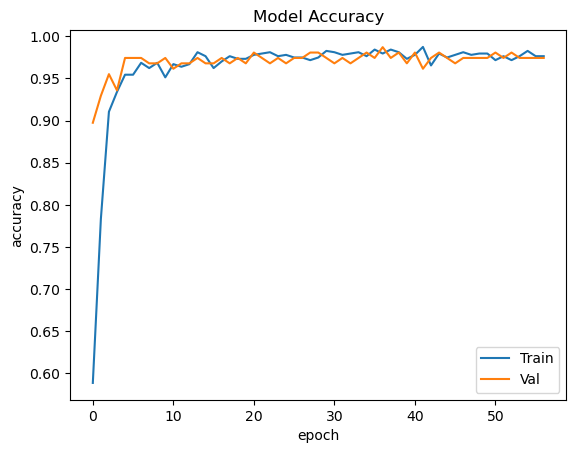

In [19]:
# CREDIT TO: https://www.tensorflow.org/lite/tutorials/pose_classification

# Visualize loss curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [20]:
# Evaluate with test dataset
test_data_csv_path = 'data\\test_csv\\squat_data_test_2.csv'

# create df from data
X_test = pd.read_csv(test_data_csv_path)
y_test = keras.utils.to_categorical(X_test.pop('63'))

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

3/3 [==============================] - 0s 6ms/step - loss: 0.0366 - accuracy: 0.9878
Loss: 0.03662409260869026
Accuracy: 0.9878048896789551


### Convert Model To TFLite 

In [21]:
# CREDIT TO https://www.tensorflow.org/lite/tutorials/pose_classification

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

print('Model size: %dKB' % (len(tflite_model) / 1024))

model_name = 'squat_classifier_v2.tflite'
model_path = os.path.join("model\\tf_lite_model", model_name)
with open(model_path, 'wb+') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Alex\AppData\Local\Temp\tmphbd4tv0h\assets
Model size: 19KB


In [22]:
# Evaluate tflite model for accuracy: CREDIT TO https://www.tensorflow.org/lite/tutorials/pose_classification

def evaluate_model(interpreter, X, y_true):
  """Evaluates the given TFLite model and return its accuracy."""
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on all given poses.
  y_pred = []
  for i in range(len(y_true)):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = X[i: i + 1].astype('float32')
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the class with highest
    # probability.
    output = interpreter.tensor(output_index)
    predicted_label = np.argmax(output()[0])
    y_pred.append(predicted_label)

  # Compare prediction results with ground truth labels to calculate accuracy.
  y_pred = keras.utils.to_categorical(y_pred)
  return accuracy_score(y_true, y_pred)

# Evaluate the accuracy of the converted TFLite model
classifier_interpreter = tf.lite.Interpreter(model_content=tflite_model)
classifier_interpreter.allocate_tensors()
print('Accuracy of TFLite model: %s' %
      evaluate_model(classifier_interpreter, X_test, y_test))

Accuracy of TFLite model: 0.9878048780487805
